# Module 2- Dynamic Sites with Selenium
The first module of the coding demo provided an overview regarding how web scraping programs are fundamentally a process of identifying how data is represented within site HTML and retrieving said information through libraries such as Beautiful Soup. Through the Beautiful Soup library, we were limited in our ability to guide our scraper through the site's content beyond what we initially see.

This is a very common situation individuals interested in building web scrapers find themselves in, and is why we'll therefore bring in Selenium as our next core tool to automate our site interactions. Throughout this module we'll be exploring how to properly initiatilize a Selenium web driver browser session, how to find HTML elements within the site with Selenium's particular methods, how to interact with site content through implementing wait times and addressing site exceptions, and how to piece all of these components together to obtain a final data set of product records collected over multiple web pages.

We'll need to `pip install selenium` directly since it doesn't come pre-installed in our Google Colab virtual Python environment, as well as download and install the [Chrome Web Driver](https://chromedriver.chromium.org/home) that we'll be using to run our own Chrome browser through Selenium into a local directory path our program will have access to.

In [ ]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install chromedriver-autoinstaller
!pip install bs4
!pip install pandas

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller
import re

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

# set up the webdriver
driver = webdriver.Chrome(options=chrome_options)

In [71]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

We'll then instantiate our Selenium-driven Chrome web browser by referring to the chromedriver executable package we've downloaded into our local directory, pass our set option parameters, and then connect to the URL of the e-commerce webscraping test site. This time we'll be collecting product information specific to the [touch phone sublisting](https://www.webscraper.io/test-sites/e-commerce/static/phones/touch?page=1) of the site, as the page features the dynamic component of having multiple pages of listed products that we toggle through by clicking on page buttons.

In [72]:
# set the target URL
url = "https://www.webscraper.io/test-sites/e-commerce/static/phones/touch?page=1"
driver.get(url)

### Finding Elements

Selenium offers a range of methods to locate elements within the website's HTML. Beautiful Soup's strategy to identify specific data was through the `find` and `find_all` methods, while Selenium's equivalent is based upon the combination of the `find_elements` method of our web driver with a designated parameter set via the `By` locater class.

Here's a visual reference of how these two libraries compare to each other in syntax to achieve the same goal:

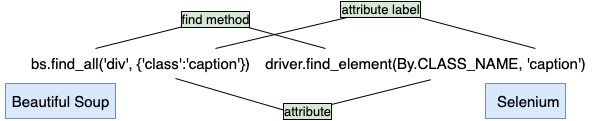

We can retrieve all of the elements on the web page with a specified class value of `caption` within the `div` HTML tag as follows:

In [73]:
for vals in driver.find_elements(By.CLASS_NAME, 'caption'):
    print(vals.text)

$24.99
Nokia 123
7 day battery
$57.99
LG Optimus
3.2" screen
$93.99
Samsung Galaxy
5 mpx. Android 5.0
$109.99
Nokia X
Andoid, Jolla dualboot
$118.99
Sony Xperia
GPS, waterproof
$499.99
Ubuntu Edge
Sapphire glass


### Interacting with Elements

The above example is only collecting the data of the first page of the site that features 6 phones, but there's actually a second page that has an additional 3 phones listed that you can access by clicking either the 2 or next arrow button on the website. This is the exact circumstance we've turned to Selenium to handle for us to coordinate clicking said buttons via our headless Chrome browser.

We can use the `page-link` class name to identify the button selection options found within the HTML:

In [74]:
for vals in driver.find_elements(By.CLASS_NAME, 'pagination'):
    print(vals.text)

‹
1
2
›


The most robust technique for building our scraper would be clicking on the 'Next' button rather than '2', since that'll allow us to replicate our code for pages on the website with more than 2 pages worth of listed products.

Specifically referencing the `rel="next"` relationship parameter that distinguishes the "next" button is a great use case for an XPath locator:
More on XPath at the bottom of the document.  

In [75]:
driver.find_element(By.XPATH, "//a[@rel='next']").text

'›'

Now that we've found a way to identify the particular button we're interested in, it's an intuitive Selenium method to actually faciliate a user click through our headless browser. Quick heads up- you're intentionally about to see an error!

In [76]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

ElementClickInterceptedException: ignored

We're encountering an unexpected raised exception here, which is liable to occur
whenever an interaction with a website via Selenium doesn't achieve the behavior the code developer was likely aiming to create. Exception messages are often quite informative towards identifying the underlying issue. The `ElemenentClickInterceptedException` refers to there being an "Other element would receive the click", and then references an `acceptContainer` div class attribute that's also within the website's HTML structure.

If we switch over to the website's Inspect tab and identify what exactly the `acceptContainer` is on the website itself, we see it's equivalent to the "We use cookies to make your Web Scraper experience better" pop-up that appears at the bottom of the site the first time you visit the page.

Although it's easy enough for us to ignore the pop-up and click on other components of the site as manual users, the pop-up is intercepting our attempted click on the next arrow button when we try to interact with the site via Selenium. The issue is simply resolved by the following:

In [77]:
driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

In [78]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

This is a great example of a common situation with building scrapers for dynamic sites, in that you often can't tell what may raise issues within your code until you're actually testing with a web driver.

What happen if we were to click the "next" button a second time? Remember that we only have two pages worth of listed phones, so we're about to see a different type of exception come up:

In [79]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

NoSuchElementException: ignored

The raised `NoSuchElementException` implies that our program doesn't think that the next arrow button exists. If you dig into the HTML on the website itself via Inspect following clicking the next arrow button, you can see that the website updates to list the button as a member of the class attibute `"page-item disabled"` subtree within the pagination container of the site. This means that the site is recognizing that there are no more pages to click the next arrow following one click to the second page.

Receiving this error reasserts for us that our Selenium-powered web driver session is indeed similar to us manually interacting with the site itself, as our past behaviors during our entire scraping workflow dictate how the website changes and therefore how we should adapt our code to accomadate the new site structure.

We can therefore adjust by prompting our program to click the previous arrow button instead, which has switched from `"page-item disabled"` class status to now a live page link after we guided our driver to move from the first to second page:

In [80]:
driver.find_element(By.XPATH, "//a[@rel='prev']").click()

This puts us back to where we started on the first page of the listed phones for sale.

### Automating Multi-Page Data Collection

Now that we've covered how to interact directly with the site through clicking elements as well as a few common complications within the click-through process to keep an eye out for, we're ready to move towards using our program to properly time the transitions between site interactions, website updates, and then correctly identifying newly displayed data.  

First, it's generally a good idea to reinitialize our web driver when automating a full workflow of data collection with Selenium to give us a clean slate without worrying about errors coming up around our previous interactions:

In [81]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

#Close previous web driver
driver.close()

# set up the webdriver
driver = webdriver.Chrome(options=chrome_options)
driver.get(url)

# Click the cookie pop-up so we don't raise a ElementClickInterceptedException
driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

We'll want to now think through how we'll collect and store data across the pages. Let's start with a simple list that holds the product titles on the first page:

In [82]:
# Create a list to hold collected product titles
element_list = []

# Collect the product titles on the first page
for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
    element_list.append(vals.text)

# Otherwise could do the following. Same thing.
element_list1 = []

for vals in driver.find_elements(By.CLASS_NAME, "title"):
    element_list1.append(vals.text)

print(element_list1)
print(element_list)

['Nokia 123', 'LG Optimus', 'Samsung Galaxy', 'Nokia X', 'Sony Xperia', 'Ubuntu Edge']
['Nokia 123', 'LG Optimus', 'Samsung Galaxy', 'Nokia X', 'Sony Xperia', 'Ubuntu Edge']


We can see that we've gathered the product titles of the six items on the first page, so we're now ready to move forward to the second page by clicking on the next arrow:

In [83]:
# Click the next arrow to the second page
driver.find_element(By.XPATH, "//a[@rel='next']").click()

This is all well and good for our interactive Colab session, but in a full-fledge automated function for web scraping, we're missing one key component still in successfully designing our data collection of the product titles to handle interacting with the two pages through button clicks.

**Implicit waits** sets a designated amount of time that the web driver will pause for. They're designed to broadly estimate how long a website will take to update following clicking on a page.

The following function combines multiple of our previous steps within the module to collect the phone names from the first page of the site, click on the cookie pop-up and next arrow button, use a 5-second wait to give the site time to update following the next arrow click, and then print out all 9 phone names that we're expecting across the two pages.

In [ ]:
#Run below if needed.
#driver.close()

In [84]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

#Close previous web driver
#driver.close()

In [85]:
def implicit_wait(url):
    # Create a new web driver connection to the site
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)


    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    element_list = []

    # Collect the product titles on the first page
    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    # Click the next arrow to the second page
    driver.find_element(By.XPATH, "//a[@rel='next']").click()

    # IMPLICIT WAIT for 5 seconds
    driver.implicitly_wait(5)

    # Collect the product titles on the second page
    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    # Print out the results stored within the list
    return print(*element_list, sep='\n')

implicit_wait(url)

Nokia 123
LG Optimus
Samsung Galaxy
Nokia X
Sony Xperia
Ubuntu Edge
Iphone
Iphone
Iphone


Success! While implicit waits are a solid technique and certainly important to be familiar with when using Selenium, I'd overall recommend using **explicit waits** over implicit waits when given the option between the two. Explicit waits employ both the specified pause time of implicit waits with the additional feature of designating conditions that Selenium will check whether they become satisfied after interacting with the web site. It therefore provides more information regarding what you're expecting to occur following interacting with the page beyond just placing a brief wait without any additional context.

Explicit waits are conducted via the `WebDriverWait` class in combination with `expected_conditions` (commonly shortened to `EC`). The one-line adaption of our implicit wait code block via the `explicit_wait` function that follows below designates what the browser will need to locate before proceeding forward with collecting data from the second page.

`EC.presence_of_element_located` specifies our web driver to pause until the titles of the phones on the second page are displayed on the website. The number you pass along with `WebDriverWait` sets the amount of time before raising an exception similar to implicit waits, but this time it's based on whether the expected condition is met within the updated website HTML. I often use `EC.element_to_be_clickable` as well to ensure that a new element is fully loaded for interaction as my expected condition parameter, while many more conditions are available [as listed here](https://selenium-python.readthedocs.io/api.html#module-selenium.webdriver.support.expected_conditions).

In [86]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

import time
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import chromedriver_autoinstaller

# setup chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# set path to chromedriver as per your configuration
chromedriver_autoinstaller.install()

#Close previous web driver
#driver.close()

In [87]:
# This function is exactly the same as above except for the use of an explicit
# wait instead of an implicit wait

def explicit_wait(url):
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    element_list = []

    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    driver.find_element(By.XPATH, "//a[@rel='next']").click()

    # EXPLICIT WAIT based on the new titles being uploaded
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH , "//a[@class='title']")))

    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    return print(*element_list, sep='\n')

explicit_wait(url)

Nokia 123
LG Optimus
Samsung Galaxy
Nokia X
Sony Xperia
Ubuntu Edge
Iphone
Iphone
Iphone


### Combining into a Pandas DataFrame

Let's finish by combining all of the core ideas we've covered to collect the prices, titles, descriptions, and number of reviews of all of the phones on the two pages of the e-commerce site. We'll know that we've succeeded if we obtain a DataFrame with 9 unique records as that's the total count of unique items listed across the two pages.

The following `phone_dataframe` function merges all of our previously covered topics into one code block. We first initiatize our web driver, connect to the e-commerce site URL, and take care of the cookie pop-up that would otherwise conflict with our page button clicks. We additionally create a data list to collect the record values for each product.

The `pages_left` variable is designed to serve as a stopping condition so Selenium will know when we've reached the last page and it can therefore break out of the data collection portion of the function. The complete workflow of data collection is based on the condition of `pages_left` exisiting, where for each round of data scraping we subsequently reduce the value by one. The idea behind this approach is that you can change `pages_left` to represent the number of pages you'd like to collect data from as needed.

The text associated with the `thumbnail` class parameter in the HTML contains the exact four data points for each record that we're interested in, so we use an XPath based on identifying the `thumbnail` attribute as our element finder.

You'll also note that our clicking of the next arrow button and then explicit wait is conditioned on the `pages_left` parameter not being at 1. This is the avoid the raised exception scenario we reviewed earlier regarding the next arrow being disabled by the site once we've reached the last page, which is equivalent to 1 in our `pages_left` condition.

In [88]:
def phone_dataframe(url):
    # Create a new web driver connection to the site
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    data_list = []

    # Set a pages left parameter that we deduct every time we scrape a full page
    pages_left = 2

    # Condition of the loop proceeding while the pages_left parameter isn't 0
    while pages_left:

        # Collect the price, title, description, and reviews on the first page
        for vals in driver.find_elements(By.XPATH, "//div[@class='thumbnail']"):
            vals = re.split(r'\n', vals.text)
            data_list.append(vals)

        # Click to the next page if we're not on the last page
        if pages_left != 1:
            driver.find_element(By.XPATH, "//a[@rel='next']").click()

        # Explicitly wait for the page navigation buttons to be clickable again
        # following our previous click
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH , "//a[@rel='prev']")))

        # Deduct our pages left stopping condition by 1 at the end of the loop
        pages_left -= 1

    # Once we've broken out of our while loop, transform our data storage list
    # into a pandas data frame
    phone_df = pd.DataFrame(data_list)

    # Set our data column labels
    phone_df.columns = ['Price', 'Title', 'Description', 'Reviews']

    # Return our data frame
    return phone_df

In [89]:
phone_df = phone_dataframe(url)
phone_df

,Price,Title,Description,Reviews
0,$24.99,Nokia 123,7 day battery,11 reviews
1,$57.99,LG Optimus,"3.2"" screen",11 reviews
2,$93.99,Samsung Galaxy,5 mpx. Android 5.0,3 reviews
3,$109.99,Nokia X,"Andoid, Jolla dualboot",4 reviews
4,$118.99,Sony Xperia,"GPS, waterproof",6 reviews
5,$499.99,Ubuntu Edge,Sapphire glass,2 reviews
6,$899.99,Iphone,White,10 reviews
7,$899.99,Iphone,Silver,8 reviews
8,$899.99,Iphone,Black,1 reviews


In [90]:
def phone_dataframe(url):
    # Create a new web driver connection to the site
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)

    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    data_list = []

    # Set a pages left parameter that we deduct every time we scrape a full page
    pages_left = 2

    # Condition of the loop proceeding while the pages_left parameter isn't 0
    while pages_left:

        # Collect the price, title, description, and reviews on the first page
        for vals in driver.find_elements(By.XPATH, "//div[@class='thumbnail']"):
            vals = re.split(r'\n', vals.text)
            data_list.append(vals)

        # Click to the next page if we're not on the last page
        if pages_left != 1:
            driver.find_element(By.XPATH, "//a[@rel='next']").click()

        # Explicitly wait for the page navigation buttons to be clickable again
        # following our previous click
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH , "//a[@rel='prev']")))

        # Deduct our pages left stopping condition by 1 at the end of the loop
        pages_left -= 1

    # Once we've broken out of our while loop, transform our data storage list
    # into a pandas data frame
    phone_df = pd.DataFrame(data_list)

    # Set our data column labels
    phone_df.columns = ['Price', 'Title', 'Description', 'Reviews']

    # Return our data frame
    return phone_df

In [91]:
phone_df = phone_dataframe(url)
phone_df

,Price,Title,Description,Reviews
0,$24.99,Nokia 123,7 day battery,11 reviews
1,$57.99,LG Optimus,"3.2"" screen",11 reviews
2,$93.99,Samsung Galaxy,5 mpx. Android 5.0,3 reviews
3,$109.99,Nokia X,"Andoid, Jolla dualboot",4 reviews
4,$118.99,Sony Xperia,"GPS, waterproof",6 reviews
5,$499.99,Ubuntu Edge,Sapphire glass,2 reviews
6,$899.99,Iphone,White,10 reviews
7,$899.99,Iphone,Silver,8 reviews
8,$899.99,Iphone,Black,1 reviews
